In [2]:
import sys
print(sys.executable)
import os

/usr/bin/python3


If you want to install some additional package

In [3]:
#import sys
#!{sys.executable} -m pip install [package]

## Loading needed packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance_matrix

from matplotlib.gridspec import GridSpec
import seaborn

## Loading some helper functions for loading data, calculating Principal Components etc.

In [5]:
## compute principal components and optionally projecting data on those (proj=True, default)
def pca(x,n_components=2,proj=True):
  U, S, Vt = np.linalg.svd(x, full_matrices=False)
  principal_components_svd = Vt[:n_components].T
  if proj:
    return x @ principal_components_svd
  else:
    return principal_components_svd

def test_split(n,split=0.5):
  idc = np.random.permutation(n)
  cut = int(n*split)
  train = idc[0:cut]
  test = idc[cut+1:]
  return np.array(train),np.array(test)

def train_test_split(x,y,cols,split=0.632):
    train,test = test_split(len(y),split=split)
    return x[train,:], x[test,:], y[train], y[test], cols[train], cols[test]

def get_baseline_prop(x,cutoff=10):
  return get_baseline(x,cutoff)/x.shape[0]

def get_baseline(x,cutoff=10):
  return np.sum(x >= cutoff,axis=0)
# Load the data files

def load_data():
  df = pd.read_excel('gmds_summer_academy_material.xlsx','Expression Data')
  var_names = pd.read_excel('gmds_summer_academy_material.xlsx','Genes')
  obs_names = pd.read_excel('gmds_summer_academy_material.xlsx','Celltypes')
  labels = pd.read_excel('gmds_summer_academy_material.xlsx','Celltypes GABA vs Gluta')
  gabagluta = labels.to_numpy()[:,0]
  gabagluta01 = np.where(gabagluta == "GABA", 1, 0).astype(np.float32)
  celltypes = obs_names.iloc()[:,0].to_numpy()
  genenames = var_names.to_numpy()[:,0]
  color_map = {
          "L4"   : "turquoise",
    "Vip"  : "darkviolet",
    "Sst"  : "gold",
    "L5a"  : "green",
    "Pvalb": "orangered",
    "L2"   : "green",
    "L5b"  : "lightgrey",
    "Smad3": "lightgrey",
    "Igtp" : "lightgrey",
    "L6b"  : "lightgrey",
    "L2/3" : "lightgrey",
    "L6a"  : "lightgrey",
    "Sncg" : "lightgrey",
    "Ndnf" : "lightgrey",
    "L5"   : "lightgrey"
  }
  cols = np.array([color_map[cat] for cat in obs_names.to_numpy()[:,0]])
  return df, gabagluta, gabagluta01, celltypes, genenames, cols

def prepare_data(df,y,cols,genenames,split=0.632,quant=0.5,cutoff=5,min_cells=10,auto_baseline=True):

    larger_cutoff = np.sum(df.to_numpy().astype(np.float32) > cutoff,axis=0)>=min_cells
    #print(larger_cutoff)
    df = df.iloc[:, larger_cutoff]
    genenames = genenames[larger_cutoff]
    #print(df.shape)
    if auto_baseline:
      quant = get_baseline_prop(df.to_numpy().astype(np.float32),cutoff=cutoff)
    else:
      quant = np.repeat(quant,df.shape[1])
    #print(quant)
    train,test = test_split(len(y),split=split)
    df_log = df.transform(lambda x: np.log(x + 0.5))
    df_log_std = df_log.transform(lambda x: (x - np.mean(x))/np.std(x)).to_numpy().astype(np.float32)
    df_log_centered = df_log.transform(lambda x: (x - np.mean(x))).to_numpy().astype(np.float32)
    # df_binary = df.transform(lambda x: ((x >= np.quantile(x,quant)))).to_numpy().astype(np.float32)

    # print(np.sum(df_binary,axis=0))
    df = df.to_numpy().astype(np.float32)
    df_binary = (df > np.quantile(df,quant)).astype(np.float32)
    df_log = df_log.to_numpy().astype(np.float32)
    return {"train":{"x":{"counts":df[train,:],
                          "log_counts":df_log[train,:],
                          "log_counts_centered":df_log_centered[train,:],
                          "log_counts_std":df_log_std[train,:],
                          "binary":df_binary[train,:]
                          },
                     "y":y[train],
                     "cols":cols[train]},
            "test":{"x":{"counts":df[test,:],
                        "log_counts":df_log[test,:],
                         "log_counts_centered":df_log_centered[test,:],
                          "log_counts_std":df_log_std[test,:],
                          "binary":df_binary[test,:]
                         },
                     "y":y[test],
                     "cols":cols[test]},
            "genes":genenames
    }
def prepare_pytorch(df,gabagluta01,cols,genenames,cutoff=10,min_cells=20,split=0.9, quant=.9):
  data = prepare_data(df,gabagluta01,cols,genenames,cutoff=10,min_cells=20,split=0.9, quant=.9)
  dstrain = CustomDataSet(torch.tensor(data["train"]["x"]["log_counts_centered"]),torch.tensor(data["train"]["y"]))
  dstest = CustomDataSet(torch.tensor(data["test"]["x"]["log_counts_centered"]),torch.tensor(data["test"]["y"]))
  traincols = np.array(data["train"]["cols"])
  testcols = np.array(data["test"]["cols"])
  return dstrain,dstest,traincols,testcols, data["genes"]

## Defining a dataset for training in pytorch
class CustomDataSet(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]

def compute_odds_ratio_binary_data(matrix):
    """
    Computes odds ratios between all pairs of columns in a 2D binary matrix.

    matrix: 2D numpy array, where rows represent samples and columns represent binary variables (0/1).

    Returns:
    A matrix of odds ratios for all pairs of columns.
    """
    num_columns = matrix.shape[1]
    odds_ratios = np.zeros((num_columns, num_columns)) + 0.5  # Matrix to store odds ratios

    for i in range(num_columns):
        for j in range(i+1, num_columns):
            # Contingency table for columns i and j
            a = np.sum((matrix[:, i] == 1) & (matrix[:, j] == 1))  # Both variables are 1
            b = np.sum((matrix[:, i] == 1) & (matrix[:, j] == 0))  # i is 1, j is 0
            c = np.sum((matrix[:, i] == 0) & (matrix[:, j] == 1))  # i is 0, j is 1
            d = np.sum((matrix[:, i] == 0) & (matrix[:, j] == 0))  # Both variables are 0
            #print(a,b,c,d)
            # Compute odds ratio (handling edge cases to avoid division by zero)
            if b * c > 0:
                odds_ratio = (a * d) / (b * c)
            else:
                odds_ratio = 0.5  # Undefined odds ratio due to zero values

            # Store the odds ratio symmetrically (since OR(i,j) = OR(j,i))
            odds_ratios[i, j] = odds_ratio
            odds_ratios[j, i] = odds_ratio

    return odds_ratios


# Optimized function to calculate intracluster and intercluster distances using numpy
def calculate_distances(X, labels):
    # Calculate the pairwise distance matrix for all points
    distance_matrix = np.sqrt(np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2))

    unique_labels = np.unique(labels)
    intracluster_distances = []
    intercluster_distances = []

    for label in unique_labels:
        # Boolean mask for current cluster points
        mask = labels == label
        intra_distances = distance_matrix[mask][:, mask]
        inter_distances = distance_matrix[mask][:, ~mask]

        # Get upper triangle of intracluster distances (excluding diagonal)
        intracluster_distances.append(intra_distances[np.triu_indices_from(intra_distances, k=1)])

        # Flatten the intercluster distances
        intercluster_distances.append(inter_distances.flatten())

    # Concatenate all distances
    intracluster_distances = np.concatenate(intracluster_distances)
    intercluster_distances = np.concatenate(intercluster_distances)

    return intracluster_distances, intercluster_distances




# Function to calculate the ratio of mean intracluster to intercluster distances
def calculate_distance_ratio(X, labels):
    intracluster_distances, intercluster_distances = calculate_distances(X, labels)
    mean_intra = np.mean(intracluster_distances)
    mean_inter = np.mean(intercluster_distances)
    ratio = mean_inter / mean_intra
    return ratio

# Function to calculate Cramer statistic
def cramer_statistic(x, y, kernel_function=None):
    if kernel_function is None:
        kernel_function = phi_cramer

    nx = x.shape[0]
    ny = y.shape[0]

    # Combine the datasets x and y
    xy = np.vstack([x, y])

    # Compute pairwise Euclidean distances
    lookup = cdist(xy, xy, 'sqeuclidean')

    # Apply the kernel function element-wise
    lookup = np.vectorize(kernel_function)(lookup)

    # Indices for the x and y parts of the matrix
    xind = np.arange(0, nx)
    yind = np.arange(nx, nx + ny)

    # Calculate the Cramer statistic
    statistic = nx * ny / (nx + ny) * (
        2 * np.sum(lookup[np.ix_(xind, yind)]) / (nx * ny)
        - np.sum(lookup[np.ix_(xind, xind)]) / (nx**2)
        - np.sum(lookup[np.ix_(yind, yind)]) / (ny**2)
    )

    return statistic

# Kernel functions
def phi_cramer(x):
    return np.sqrt(x) / 2

def train_model(model, train_dataset, test_dataset, epochs=20, batch_size=10, learning_rate=1e-3, is_vae=False, klfactor=1.0):
    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss values for plotting
    train_losses = []
    test_losses = []

    # Training and Evaluation
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for  batch_idx, (data,labels) in enumerate(train_loader):
            if isinstance(data, (list, tuple)):
                data = data[0]
            data = data.to(next(model.parameters()).device)  # move to device (GPU or CPU)

            optimizer.zero_grad()

            if is_vae:
                recon_batch, mu, log_var = model(data)
                loss = loss_function(recon_batch, data, mu, log_var, klfactor)
            else:
                recon_batch, z = model(data)
                loss = loss_function_ae(recon_batch, data)  # AE only uses reconstruction loss

            loss.backward()
            # print(train_loss)
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in test_loader:
              if isinstance(data, (list, tuple)):
                data = data[0]
                data = data.to(next(model.parameters()).device)

                if is_vae:
                    recon_batch, mu, log_var = model(data)
                    loss = loss_function(recon_batch, data, mu, log_var, klfactor)
                else:
                    recon_batch, z = model(data)
                    loss = loss_function_ae(recon_batch, data)

                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")



    print("Training complete.")
    return train_losses, test_losses

# Usage example:
# model = VAE(input_dim=10, hidden_dim=20, latent_dim=2)
# train_model(model, train_dataset, test_dataset, epochs=50, is_vae=True)

def plot_test_train_loss(train_losses, test_losses):
    # Plot train and test losses
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.show()



### Loading all necessary data
Run this function again in case some variables are overwritten and code breaks

In [6]:
df, gabagluta, gabagluta01, celltypes, genenames, cols = load_data()

In [7]:
# Display the first few rows of each dataframe
df.head()

0            1           2    3    4           5    6         7    \
0     0.000000     0.000000   64.015161  0.0  0.0    0.000000  0.0  0.000000   
1     0.000000  3379.970322  466.996514  0.0  0.0    0.000000  0.0  9.230775   
2  1827.331763     1.845081    0.000000  0.0  0.0    0.000000  0.0  0.000000   
3     0.000000     4.389982   15.946611  0.0  0.0  219.383886  0.0  0.000000   
4     0.000000     0.000000  175.019066  0.0  0.0    0.000000  0.0  0.000000   

   8    9    ...  170  171  172       173  174  175           176  177  178  \
0  0.0  0.0  ...  0.0  0.0  0.0  1.359133  0.0  0.0  89572.269764  0.0  0.0   
1  0.0  0.0  ...  0.0  0.0  0.0  0.000000  0.0  0.0  17764.934176  0.0  0.0   
2  0.0  0.0  ...  0.0  0.0  0.0  0.000000  0.0  0.0      0.000000  0.0  0.0   
3  0.0  0.0  ...  0.0  0.0  0.0  4.938730  0.0  0.0  57210.223942  0.0  0.0   
4  0.0  0.0  ...  0.0  0.0  0.0  0.000000  0.0  0.0  62089.677759  0.0  0.0   

   179  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows x 180 columns]

### Inspecting data

In [8]:
gabagluta

array(['GABA', 'GABA', 'Glutamate', ..., 'GABA', 'GABA', 'GABA'],
      dtype=object)

In [9]:
gabagluta01

array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)

In [10]:

cols

array(['darkviolet', 'darkviolet', 'turquoise', ..., 'darkviolet',
       'darkviolet', 'darkviolet'], dtype='<U10')

In [11]:
genenames

array(['Adora1', 'Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adrb1', 'Adrb2',
       'Aqp4', 'Arf5', 'Batf3', 'Bcl6', 'Bgn', 'Brca1', 'C1qb', 'Calb2',
       'Car12', 'Car4', 'Cbln4', 'Cd9', 'Cdh13', 'Cdk6', 'Chat', 'Chodl',
       'Chrm1', 'Chrm2', 'Chrm3', 'Chrm4', 'Chrna1', 'Chrna2', 'Chrna3',
       'Chrna4', 'Chrna5', 'Chrna7', 'Chrnb1', 'Chrnb2', 'Chrnb3', 'Cnr1',
       'Cnr2', 'Col6a1', 'Cpne5', 'Crip1', 'Crispld2', 'Cspg4', 'Ctgf',
       'Ctss', 'Ctxn3', 'Cx3cr1', 'Cxcl14', 'Ddit4l', 'Deptor', 'Drd1a',
       'Drd5', 'Enpp2', 'Enpp6', 'Exosc7', 'F3', 'Flt1', 'Foxp2', 'Frmd7',
       'Fyn', 'Gabbr1', 'Gabbr2', 'Gabra1', 'Gabra2', 'Gabra3', 'Gabra4',
       'Gabra5', 'Gabrb1', 'Gabrb2', 'Gabrb3', 'Gabrd', 'Gabrg1',
       'Gabrg2', 'Gabrg3', 'Gfap', 'Gja1', 'Glra2', 'Glra3', 'Glrb',
       'Gpc3', 'Gpr34', 'Gpx3', 'Gria1', 'Gria2', 'Gria3', 'Gria4',
       'Grid1', 'Grik1', 'Grik2', 'Grik3', 'Grik4', 'Grik5', 'Grin1',
       'Grin2a', 'Grin2b', 'Grin2d', 'Grin3a', 'Grina', 'Grm1',

In [12]:
df_log = df.transform(lambda x: np.log(x + 0.5))

In [13]:
df_log_std = df_log.transform(lambda x: (x - np.mean(x))/np.std(x))

In [14]:
df_log_centered = df_log.transform(lambda x: (x - np.mean(x)))

In [15]:
df_log_std.std(axis=0)

0      1.000328
1      1.000328
2      1.000328
3      1.000328
4      1.000328
         ...   
175    1.000328
176    1.000328
177    1.000328
178    1.000328
179    1.000328
Length: 180, dtype: float64

In [16]:
np.random.randint(0,179,4)

array([ 55, 113,  49,  31])

#### Plotting distributions of a random selection of genes
log transformed counts, centered

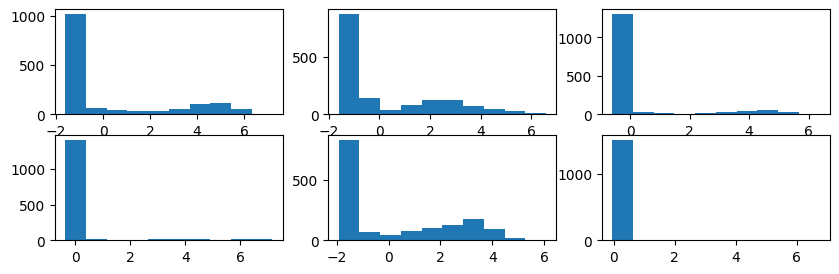

In [17]:
x =  df_log_centered.to_numpy().astype(np.float32)
plt.figure(figsize=(10, 3), dpi=100)
np.random.randint(0,179,6)
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.hist(x[:,i+1])

#### Plotting distributions of a random selection of genes
 counts

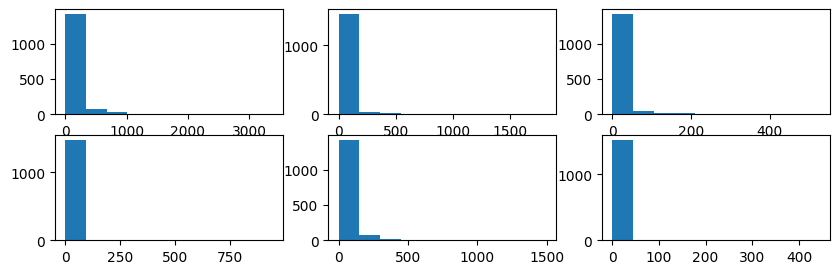

In [18]:
x =  df.to_numpy().astype(np.float32)
plt.figure(figsize=(10, 3), dpi=100)
np.random.randint(0,179,6)
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.hist(x[:,i+1])

### Inspecting the observations in the expression data set
rows are samples (cells), columns are genes
color indicates cell type

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 400x400 with 0 Axes>

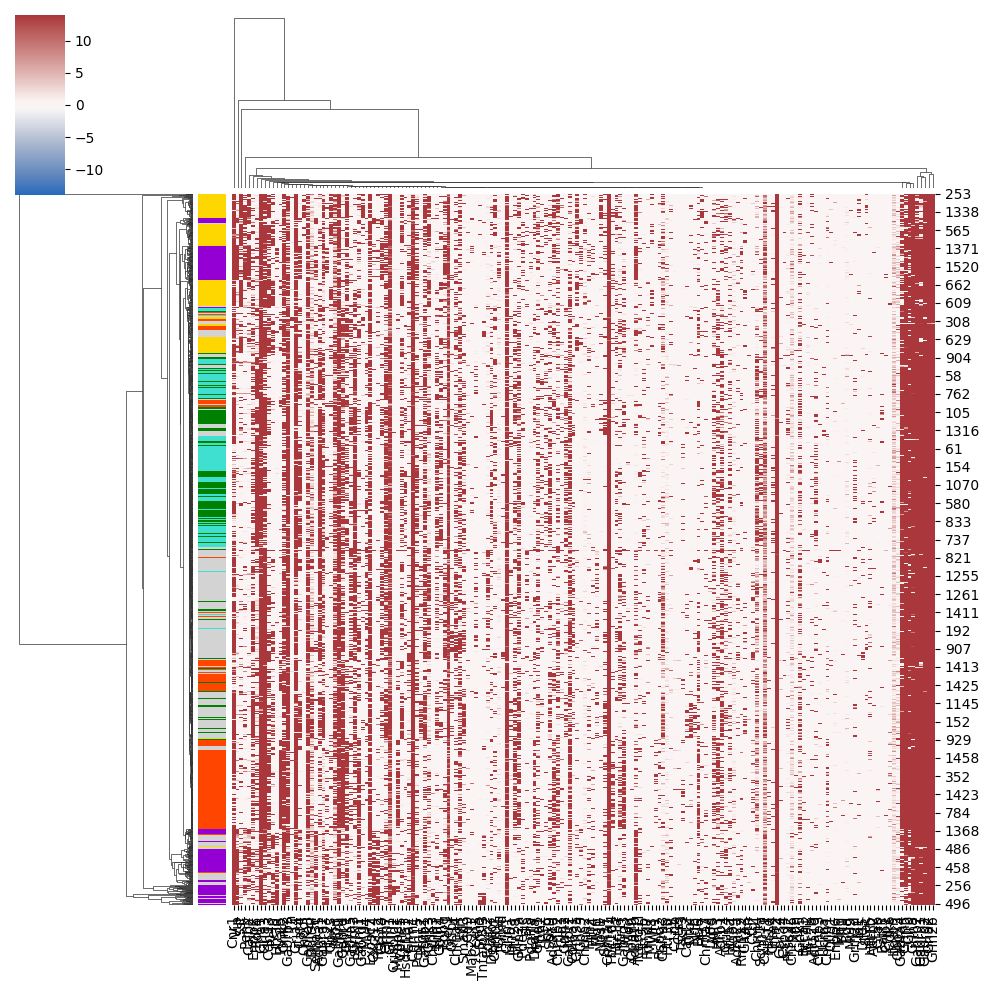

In [19]:
plt.figure(figsize=(4, 4), dpi=100)
seaborn.clustermap(x,row_colors=cols,cmap="vlag",xticklabels=genenames,vmin=-14,vmax=14,center=0)

### Starting with computing Principial components from the log transformed, centered data

In [20]:
x =  df_log_centered.to_numpy().astype(np.float32)

In [21]:
N = x.shape[0]
## Covariance matrix
cov = 1 / (N-1) * x.T @ x
## Eigenvalue decomposition into eigenvalues (V) and eigenvectors (PC)
V, PC = np.linalg.eig(cov)
## sorting according to variance (eigenvalues)
idx = np.argsort(V)[::-1]
V = V[idx]
PC = PC[:,idx]
## Projecting data on the first 2 PCs
pca_proj = x @ PC[:,0:2]

Text(0, 0.5, 'Principal Component 2')

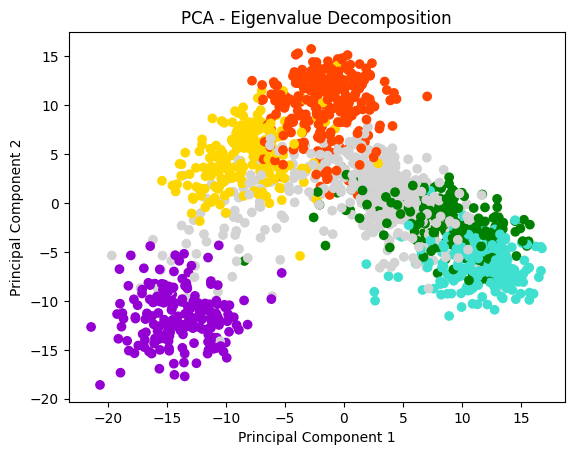

In [22]:
# Plot projections
plt.subplot(1, 1, 1)
plt.scatter(pca_proj[:, 0],  pca_proj[:, 1],color=cols)
plt.title('PCA - Eigenvalue Decomposition')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

## Prepare Data for PyTorch

In [23]:
class CustomDataSet(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]


 PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [24]:
## Random seed for reproducible results
torch.manual_seed(21)
## splitting data into "split" training and remainder test data. Genes are filtered for a mininmum (cutoff) expression level (counts) in at least
## "min_cells"
data = prepare_data(df,gabagluta01,cols,genenames,cutoff=10,min_cells=20,split=0.8, quant=.9)
x = torch.tensor(data["train"]["x"]["log_counts_centered"]) ## expression matrix
y = torch.tensor(data["train"]["y"]) ## labels indicating membership to GABAergic or Glutamatergic type neurons (binary)
## Test data
dstrain = CustomDataSet(x,y)
## Training data
dstest = CustomDataSet(torch.tensor(data["test"]["x"]["log_counts_centered"]),torch.tensor(data["test"]["y"]))
## cell membership expressed as colors for plotting
traincols = np.array(data["train"]["cols"])
testcols = np.array(data["test"]["cols"])
## putting training data into a dataloader object which emits the data in batches of "batch_size" during training. At each full iteration (epoch)
## data is shuffled (shuffle=True)
dl = DataLoader(dstrain,batch_size=10,shuffle=True)

## PCA with stochastic gradient descent

In [25]:
class PCA_SGD(nn.Module):
    def __init__(self, n_components, input_dim):
        super(PCA_SGD, self).__init__()
        self.n_components = n_components
        # Linear transformation for PCA
        self.linear = nn.Linear(input_dim, n_components, bias=False)

    def forward(self, x):
        # Dimensionality reduction
        return self.linear(x)

    def reconstruct(self, x):
        # Reconstruct data by projecting back using the transpose of the weight matrix
        return self.linear.weight.t() @ self.linear(x).t()



In [26]:
# Assuming input_dim = dstrain.x.shape[1] which are the number of columns in the expression set and we want 2 principal components
pca_sgd = PCA_SGD(n_components=2, input_dim=dstrain.x.shape[1])

# Optimizer and Loss function
optimizer = optim.SGD(pca_sgd.parameters(), lr=0.01)


In [27]:
# Training loop
epochs = 100
train_losses = []
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data_,labels_) in enumerate(dl):
      optimizer.zero_grad()

      # Forward pass (PCA projection)
      projected_data = pca_sgd(data_)

      # Reconstruct the data
      reconstructed_data = pca_sgd.reconstruct(data_).t()  # Transpose to match original shape

      # Compute reconstruction loss
      loss = F.mse_loss(reconstructed_data, data_)

      # Backpropagation and optimization step
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    avg_train_loss = train_loss / len(dl.dataset)
    train_losses.append(avg_train_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/100], Loss: 4.4356
Epoch [11/100], Loss: 3.3499
Epoch [21/100], Loss: 3.9161
Epoch [31/100], Loss: 3.6250
Epoch [41/100], Loss: 4.0585
Epoch [51/100], Loss: 3.9100
Epoch [61/100], Loss: 3.4054
Epoch [71/100], Loss: 3.2891
Epoch [81/100], Loss: 3.6343
Epoch [91/100], Loss: 3.7073


### Plotting the change of the Loss in the course of training

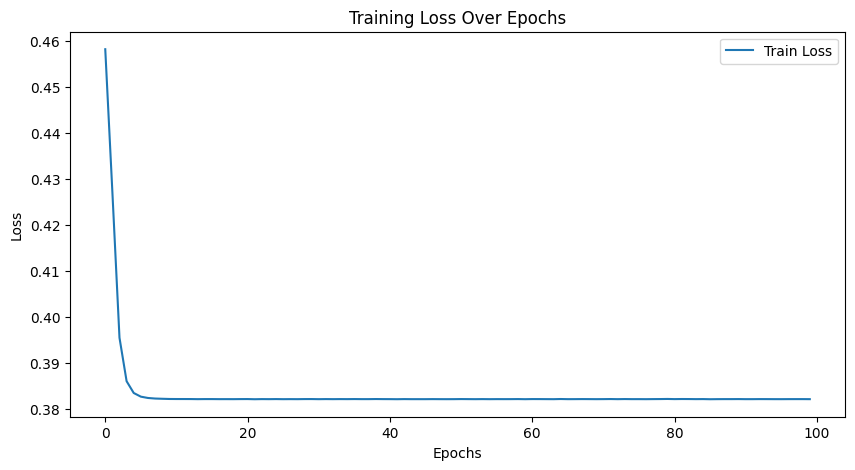

In [28]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### Plot the trained weight matrix

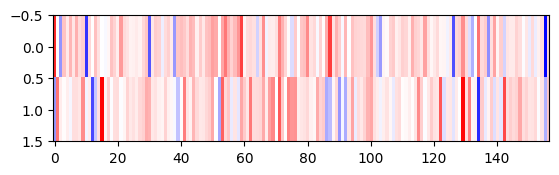

In [29]:
plt.imshow(pca_sgd.linear.weight.detach(),aspect=20,cmap='bwr',interpolation="None")

### plot the  gradients of the last update

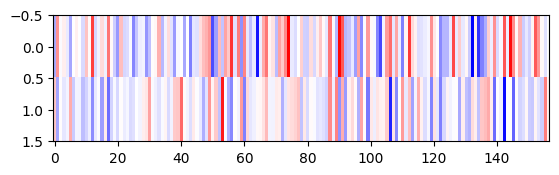

In [30]:
plt.imshow(pca_sgd.linear.weight.grad,aspect=20,cmap='bwr',interpolation="None")

## Tasks and Questions Stochastic Gradient Descent
Get familiar with Pytorchs interface for training model parameters. The following tasks might help you:

1. what happens if you comment out "loss.backward()"
2. what happens if you swap "reconstructed_data" and data_ in ``F.mse_loss(reconstructed_data, data_)``
3. what happens if you comment out "optimizer.zero_grad()"
4. what is the loss function
5. what happens if you change ``lr`` in ``optim.SGD(pca_sgd.parameters(), lr=0.01)``
6. what controls ``lr``
7. what is controlled by ``epochs``
8. could you have used something different for ``optim.SGD``
9. what are the parameters in ``class PCA_SGD(nn.Module):`` that we optimize
10. what are the methods ``forward`` and ``reconstruct doing``
11. why did we select ``bias=False`` in ``self.linear = nn.Linear(input_dim, n_components, bias=False)``


> Add blockquote



### Your Answers

1.
2.
...

### Comparing PCs computed by conventional approaches with PCs computed with stochstic gradient descent (SGD)

What is happening in the next line, do you have an Idea ?
Hint: compare with the following two lines

In [31]:
pcs_sgd = pca_sgd(dstest.x).detach().numpy()

In [32]:
## computing PCs for the training data with Singular Value decomposition
pca_svd = pca(dstrain.x,proj=False)

In [33]:
## Projecting Test data on the computed PCs
pcs_svd = dstest.x @ pca_svd

Text(0, 0.5, 'Principal Component 2')

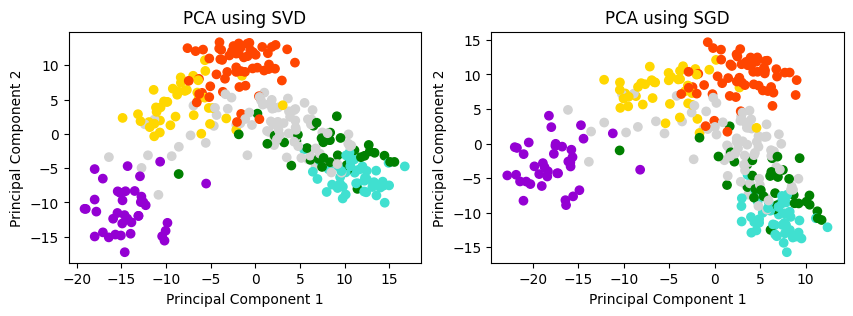

In [34]:
# Plot SVD projections
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.scatter(pcs_svd[:, 0],  pcs_svd[:, 1],color=testcols)
plt.title('PCA using SVD')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Plot projections from SGD
plt.subplot(1, 2, 2)
plt.scatter(pcs_sgd[:, 0], pcs_sgd[:, 1], color=testcols)
plt.title('PCA using SGD')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

## Tasks and questions Stochastic Gradient Descent 2
1. do you observed difference between SVD and SGD solution ?
2. where would you see the benefits of each method ?

### Your Answers

1.
2.
...

## Deep Learning


### Autoencoder

In [35]:
## Defining the Autoencoder Model
class AE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=20, latent_dim=2,class_dim=1):
        super(AE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)


        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.cls = nn.Linear(latent_dim,class_dim) ## not used here, so you can ignore it

    def encode(self, x):
        h1 = F.tanh(self.fc1(x))
        return self.fc21(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        z = self.encode(x)
        #print(mu)
        return self.decode(z), z
    ## optionally train a classifier - we will likely not use it
    def classifier(self,z):
        return F.sigmoid(self.cls(z))

## Main loss function, we will not use it now so you can ignore it here
def loss_function_ae(recon_x, x):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    return MSE

## Additional loss function - we will likely not use it
def classifier_loss(yhat,y):
    return F.binary_cross_entropy(yhat,y.view(1,1))#y.type(torch.LongTensor))

In [36]:
## Training Function
def train_ae(model, dataloader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x,labels) in enumerate(dataloader):
            optimizer.zero_grad()
            recon_x, mu = model.forward(x)
            loss = F.mse_loss(recon_x, x, reduction='sum')
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {overall_loss / len(dataloader.dataset):.4f}")

### Setting up the Autoencoder and Training

In [37]:
torch.manual_seed(20)
ae = AE(input_dim=dstrain.x.shape[1],hidden_dim=300,latent_dim=2)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
epochs = 10

In [38]:
train_ae(ae,dl,optimizer)

Epoch 1, Loss: 616.8378
Epoch 2, Loss: 558.7143
Epoch 3, Loss: 544.2060
Epoch 4, Loss: 534.7382
Epoch 5, Loss: 527.0277
Epoch 6, Loss: 521.0806
Epoch 7, Loss: 516.0599
Epoch 8, Loss: 511.5756
Epoch 9, Loss: 507.5195
Epoch 10, Loss: 503.9650


In [39]:
zs = ae(dstest.x)[1].detach().numpy()

Text(0, 0.5, 'Z 2')

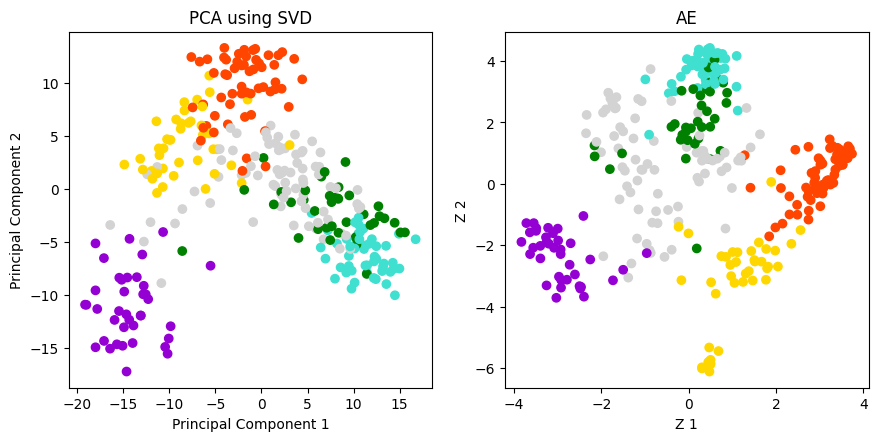

In [40]:
# Plot SVD projections
plt.figure(figsize=(10, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.1)
plt.subplot(1, 2, 1)
plt.scatter(pcs_svd[:, 0],  pcs_svd[:, 1],color=testcols)
plt.title('PCA using SVD')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Plot projections from SGD
plt.subplot(1, 2, 2)
plt.scatter(zs[:, 0], zs[:, 1], color=testcols)
plt.title('AE')
plt.xlabel('Z 1')
plt.ylabel('Z 2')


## Tasks and Questions Autoencoder
1. Compare with setting up and training ```PCA_SGD``
  2. which settings are different, which are additional
    1. what is ``hidden_dim``
    2. what is ``latent_dim``
    3. what is ``fc1, fc21, fc22, fc3, fc4``
    4. what are ``F.relu`` and ``F.tanh``
  3. what is happening in ``zs = ae(dstest.x)[1].detach().numpy()``
    1. can you find an analogue in ``PCA_SGD``
2. what happens if you change ``hidden_dim`` ?
3. what happens if you remove ``F.relu`` and ``F.tanh`` or swap these
4. which benefits / disadvantages do you see in both approaches


### Your Answers

1.
2.
...

## Variational Autoencoder (VAE)

In [41]:
# Defining the VAE class with the necessary PyTorch components
class VAE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=20, latent_dim=2):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, log_var = self.encode(x)
        #print(mu)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
## we will need that function later but not now so you can ignore it here
def loss_function(recon_x, x, mu, log_var,klfactor =1):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + klfactor * KLD

In [42]:
def train_vae(model, dataloader, optimizer, epochs=10,klfactor=1):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x,labels) in enumerate(dataloader):
            optimizer.zero_grad()
            xhat, mu, log_var = model.forward(x)
            MSE = F.mse_loss(xhat, x, reduction='sum')
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = MSE + klfactor * KLD
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {overall_loss / len(dataloader.dataset):.4f}")

In [43]:
torch.manual_seed(20)
vae = VAE(input_dim=dstrain.x.shape[1],hidden_dim=300,latent_dim=2)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 10
train_vae(vae,dl,optimizer,klfactor=1)

Epoch 1, Loss: 662.5080
Epoch 2, Loss: 601.1160
Epoch 3, Loss: 574.6697
Epoch 4, Loss: 557.5242
Epoch 5, Loss: 547.9369
Epoch 6, Loss: 540.9211
Epoch 7, Loss: 534.7706
Epoch 8, Loss: 530.7477
Epoch 9, Loss: 526.1847
Epoch 10, Loss: 522.7889


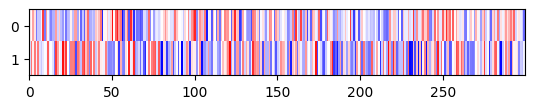

In [44]:
plt.imshow(vae.fc21.weight.grad,aspect=20,cmap='bwr',interpolation="None")

In [45]:
def sample_posterior(model, x):
    with torch.no_grad():
        mu, log_var = model.encode(x)
        z = model.reparameterize(mu, log_var)
        return model.decode(z), z

def sample_prior(model,n):
    p = model.fc22.weight.shape[0]
    with torch.no_grad():
        mu, log_var = torch.zeros([n,p]),torch.zeros([n,p])
        z = model.reparameterize(mu, log_var)
        return model.decode(z), z

In [46]:
zs_vae = sample_posterior(vae,dstest.x)[1].detach().numpy()

Text(0, 0.5, 'Z 2')

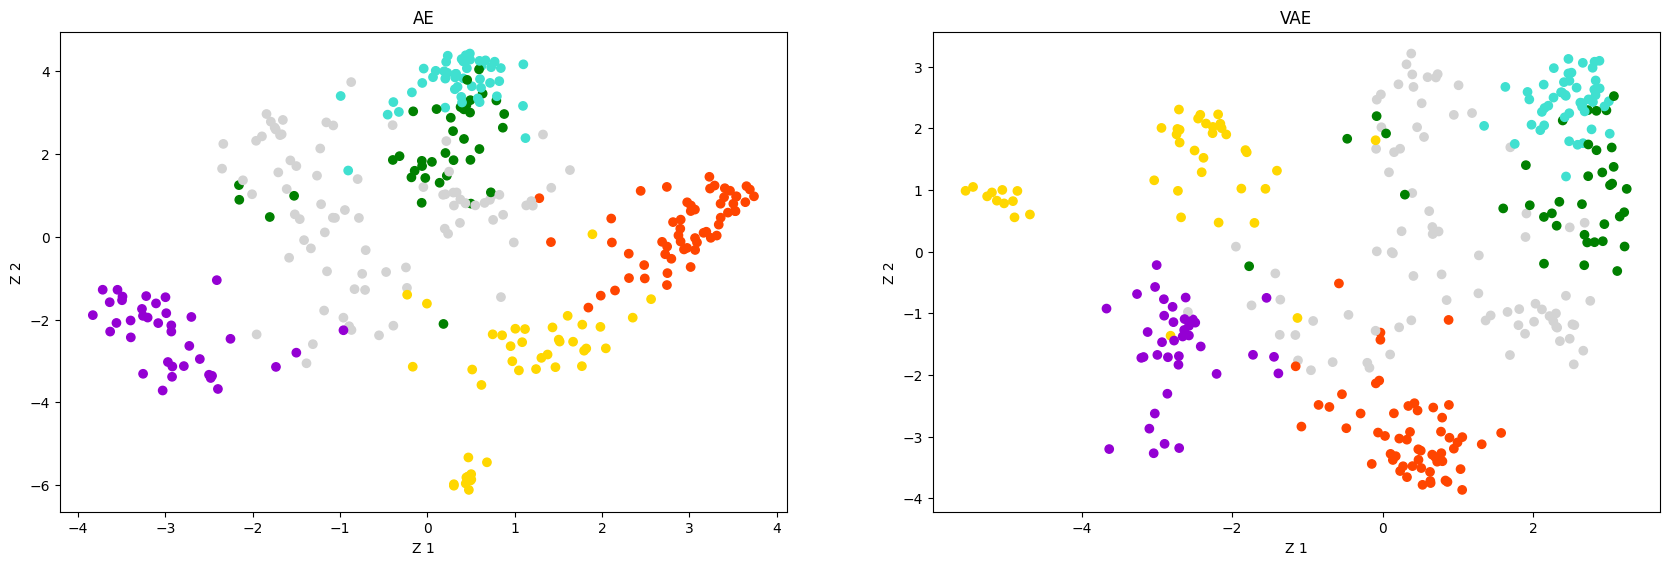

In [47]:
# Plot SVD projections
plt.figure(figsize=(20, 6))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.subplot(1, 2, 1)
plt.scatter(zs[:, 0],  zs[:, 1],color=testcols)
plt.title('AE')
plt.xlabel('Z 1')
plt.ylabel('Z 2')

plt.subplot(1, 2, 2)
plt.scatter(zs_vae[:, 0],  zs_vae[:, 1],color=testcols)
plt.title('VAE')
plt.xlabel('Z 1')
plt.ylabel('Z 2')


## Tasks and Questions Variational Autoencoder
1. Compare the ``class VAE`` with ``class AE``
  1. similarities, dissimilarities? (there are components you can ignore - see comments)
2. Compare ``train_ae`` with ``train_vae`` (tip: copy code from ``train_ae`` next to ``train_vae`` for easier comparison)
  1. similarities, dissimilarities ?
3. which part in ``train_vae`` computes the Evidence lower bound (ELBO) ?
4. what do ``sample_prior`` and ``sample_posterior``
5. how does the result of ``zs = ae(dstest.x)[1].detach().numpy()`` relates to the result of ``zs_vae = sample_posterior(vae,dstest.x)[1].detach().numpy()``
6. compare projections (dimension reduction) made with AE and VAE
  1. do they change if you rerun ``zs = ae(dstest.x)[1].detach().numpy()`` and ``zs_vae = sample_posterior(vae,dstest.x)[1].detach().numpy()``?
7. which benefits / disadvantages do you see in both approaches


## Compare AE and VAE in terms of overfitting in response to different numbers of available observations

You can now compare the behaviour of AE and VAE with regards to overfitting. You will use the convenience function ``train_model`` which can train both AE and VAE and will monitor the loss in test and training data. Set switch ``is_vae=True`` vor VAE and ``is_vae=False`` for AE.
An example usage is demonstrated below for AE.

### Tasks
1. use ``dstrain, dstest, traincols, testcols = prepare_pytorch(df,gabagluta01,cols,genenames,cutoff=10,min_cells=20,split=0.9, quant=.9)``

1.   List item
2.   List item

to create resampled datasets where you can change the proportion of training data using ``split`` from 0 to 1 (the higher, the more training data).
2. fit AE and VAE and plot ``trainloss and testloss``
3. what do you observe in terms of the trainig and testloss ?
4. use training parameter (hyperparameter) ``klfactor`` in VAE (is only functional in VAE)
  1. what is the effect on overfitting
5. what does ``klfactor`` control in VAE
6. additional you can change ``hidden_dim`` and ``latent_dim`` and compare the effect on overfitting in combination with different amount of training data

In [48]:
dstrain, dstest, traincols, testcols, genes = prepare_pytorch(df,gabagluta01,cols,genenames,cutoff=10,min_cells=20,split=0.9, quant=.9)

In [49]:
ae_ = AE(input_dim=dstrain.x.shape[1], hidden_dim=100, latent_dim=2)
trainloss, testloss = train_model(ae_, dstrain, dstest, epochs=40, is_vae=False,klfactor=10)

Epoch [1/40] - Train Loss: 637.898163, Test Loss: 582.535922
Epoch [2/40] - Train Loss: 568.346211, Test Loss: 557.683412
Epoch [3/40] - Train Loss: 551.728210, Test Loss: 548.787084
Epoch [4/40] - Train Loss: 543.926896, Test Loss: 542.337736
Epoch [5/40] - Train Loss: 537.305597, Test Loss: 540.372415
Epoch [6/40] - Train Loss: 531.947174, Test Loss: 535.577150
Epoch [7/40] - Train Loss: 526.992411, Test Loss: 534.028229
Epoch [8/40] - Train Loss: 522.585780, Test Loss: 530.628203
Epoch [9/40] - Train Loss: 518.198350, Test Loss: 526.569203
Epoch [10/40] - Train Loss: 514.349628, Test Loss: 523.343854
Epoch [11/40] - Train Loss: 510.194041, Test Loss: 520.109769
Epoch [12/40] - Train Loss: 507.122280, Test Loss: 517.930391
Epoch [13/40] - Train Loss: 503.584622, Test Loss: 515.827802
Epoch [14/40] - Train Loss: 500.558746, Test Loss: 513.887347
Epoch [15/40] - Train Loss: 498.077077, Test Loss: 513.154657
Epoch [16/40] - Train Loss: 495.685838, Test Loss: 510.981842
Epoch [17/40] - T

In [50]:
testloss

[582.5359224018298,
 557.6834122507196,
 548.787084479081,
 542.337736430921,
 540.3724148398951,
 535.5771500436883,
 534.0282287597656,
 530.6282027395148,
 526.5692034269634,
 523.3438535991468,
 520.1097693192331,
 517.9303910104852,
 515.8278021561472,
 513.8873467696341,
 513.1546574642783,
 510.9818420410156,
 509.0479599802118,
 506.8717289974815,
 505.7375006424753,
 504.4517428749486,
 505.85285307231703,
 504.68432777806333,
 503.8285699141653,
 502.60941354851974,
 500.5266057064659,
 501.3125803094161,
 501.49773768374797,
 500.35262258429276,
 500.8676476729544,
 499.2399324115954,
 500.313307109632,
 499.17988506116365,
 499.36269499126234,
 499.2328475149054,
 497.3855912057977,
 498.5654626143606,
 497.9502017372533,
 496.70529817280016,
 497.22034976356906,
 497.76132523386104]

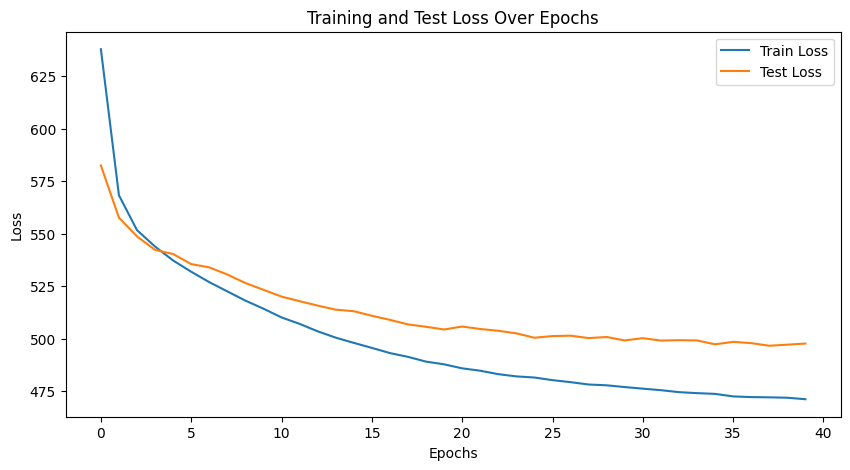

In [51]:
plot_test_train_loss(trainloss, testloss)

## Inspecting samples from VAE
Use the function ``sample_prior`` and ``sample_posterior`` to sample synthetic observations from the VAE.

Then inspect how they change conditional on the hyperparameters of the VAE.

### Interesting Hyperparameters
1. ``epoch``
2. ``hidden_dim``
3. ``latent_dim``
4. ``klfactor``

In [52]:
vae = VAE(input_dim=dstrain.x.shape[1], hidden_dim=100, latent_dim=2)
trainloss, testloss = train_model(vae, dstrain, dstest, epochs=10, is_vae=True,klfactor=1)

Epoch [1/10] - Train Loss: 671.984757, Test Loss: 603.932504
Epoch [2/10] - Train Loss: 599.719701, Test Loss: 579.515945
Epoch [3/10] - Train Loss: 580.533188, Test Loss: 572.635833
Epoch [4/10] - Train Loss: 568.628647, Test Loss: 562.714601
Epoch [5/10] - Train Loss: 559.398288, Test Loss: 557.942575
Epoch [6/10] - Train Loss: 552.374808, Test Loss: 554.049089
Epoch [7/10] - Train Loss: 547.048139, Test Loss: 550.961101
Epoch [8/10] - Train Loss: 542.391116, Test Loss: 546.523421
Epoch [9/10] - Train Loss: 538.401848, Test Loss: 546.869437
Epoch [10/10] - Train Loss: 535.502684, Test Loss: 543.255961
Training complete.


In [53]:
xhat, zhat = sample_posterior(vae,dstrain.x)
xhat_post = xhat.detach().numpy()
zhat_post = zhat.detach().numpy()

In [54]:
xhat, zhat = sample_prior(vae,1000)
xhat = xhat.detach().numpy()
zhat = zhat.detach().numpy()


In [55]:
xhat_pc = pca(xhat)
zhat_pc = pca(zhat)
x_pc = pca(dstrain.x)
xhat_post_pc = pca(xhat_post)
zhat_post_pc = pca(zhat_post)
x_pc = pca(dstrain.x)

### Samples from Prior distribution

Text(0, 0.5, 'Principal Component 2')

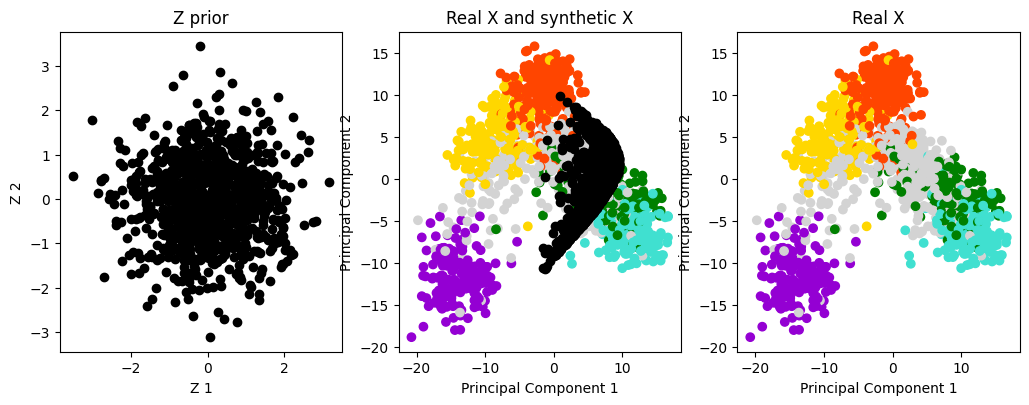

In [56]:
plt.figure(figsize=(12, 4),dpi=100)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.subplot(1, 3, 1)
plt.scatter(zhat_pc[:, 0],  zhat_pc[:, 1],color="black")
plt.title('Z prior')
plt.xlabel('Z 1')
plt.ylabel('Z 2')
plt.subplot(1, 3, 2)
plt.scatter(x_pc[:, 0],  x_pc[:, 1],color=traincols)
plt.scatter(xhat_pc[:, 0],  xhat_pc[:, 1],color="black")
plt.title('Real X and synthetic X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.subplot(1, 3, 3)
plt.scatter(x_pc[:,0],  x_pc[:, 1],color=traincols)



plt.title('Real X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

### Sample from posterior distribution

Text(0, 0.5, 'Principal Component 2')

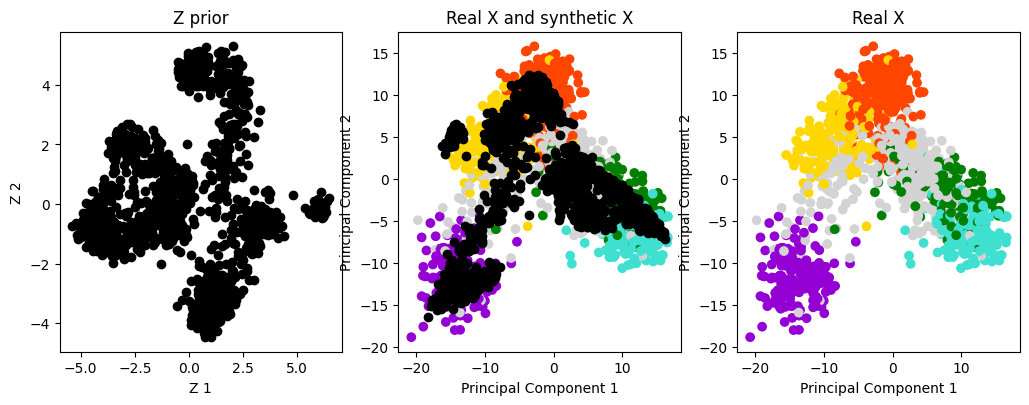

In [57]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.subplot(1, 3, 1)
plt.scatter(zhat_post_pc[:, 0],  zhat_post_pc[:, 1],color="black")
plt.title('Z prior')
plt.xlabel('Z 1')
plt.ylabel('Z 2')
plt.subplot(1, 3, 2)
plt.scatter(x_pc[:, 0],  x_pc[:, 1],color=traincols)
plt.scatter(xhat_post_pc[:, 0],  xhat_post_pc[:, 1],color="black")
plt.title('Real X and synthetic X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.subplot(1, 3, 3)
plt.scatter(x_pc[:,0],  x_pc[:, 1],color=traincols)



plt.title('Real X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

### Investigating how Covariance / Correlation is preserved in synthetic data

In [58]:
## Compute correlation between features in synthetic and real data
xhat_cor = np.corrcoef(xhat.T)
xhat_post_cor = np.corrcoef(xhat_post.T)
x_cor = np.corrcoef(dstrain.x.T)

In [59]:
## resort correlation matrix of real using euclidean distance between features. Its just for making the results more interpretable.
x_cor_dist = distance_matrix(x_cor, x_cor)
x_cor_order = np.array(dendrogram(linkage(x_cor_dist,"single"), no_plot=True)['leaves'])

<ipython-input-59-5c4c02820860>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  x_cor_order = np.array(dendrogram(linkage(x_cor_dist,"single"), no_plot=True)['leaves'])


In [60]:
## Resort correlations matrices of real and synthetic data according to similarities of of features in real data
x_cor = x_cor[:,x_cor_order]
x_cor = x_cor[x_cor_order,:]
xhat_cor = xhat_cor[:,x_cor_order]
xhat_cor = xhat_cor[x_cor_order,:]
xhat_post_cor = xhat_post_cor[:,x_cor_order]
xhat_post_cor = xhat_post_cor[x_cor_order,:]


In [61]:
## combine sorted correlations in synthetic and real data
xfus = np.triu(xhat_cor) + np.tril(x_cor)
x_postfus = np.triu(xhat_post_cor) + np.tril(x_cor)

### Correlations in samples from prior

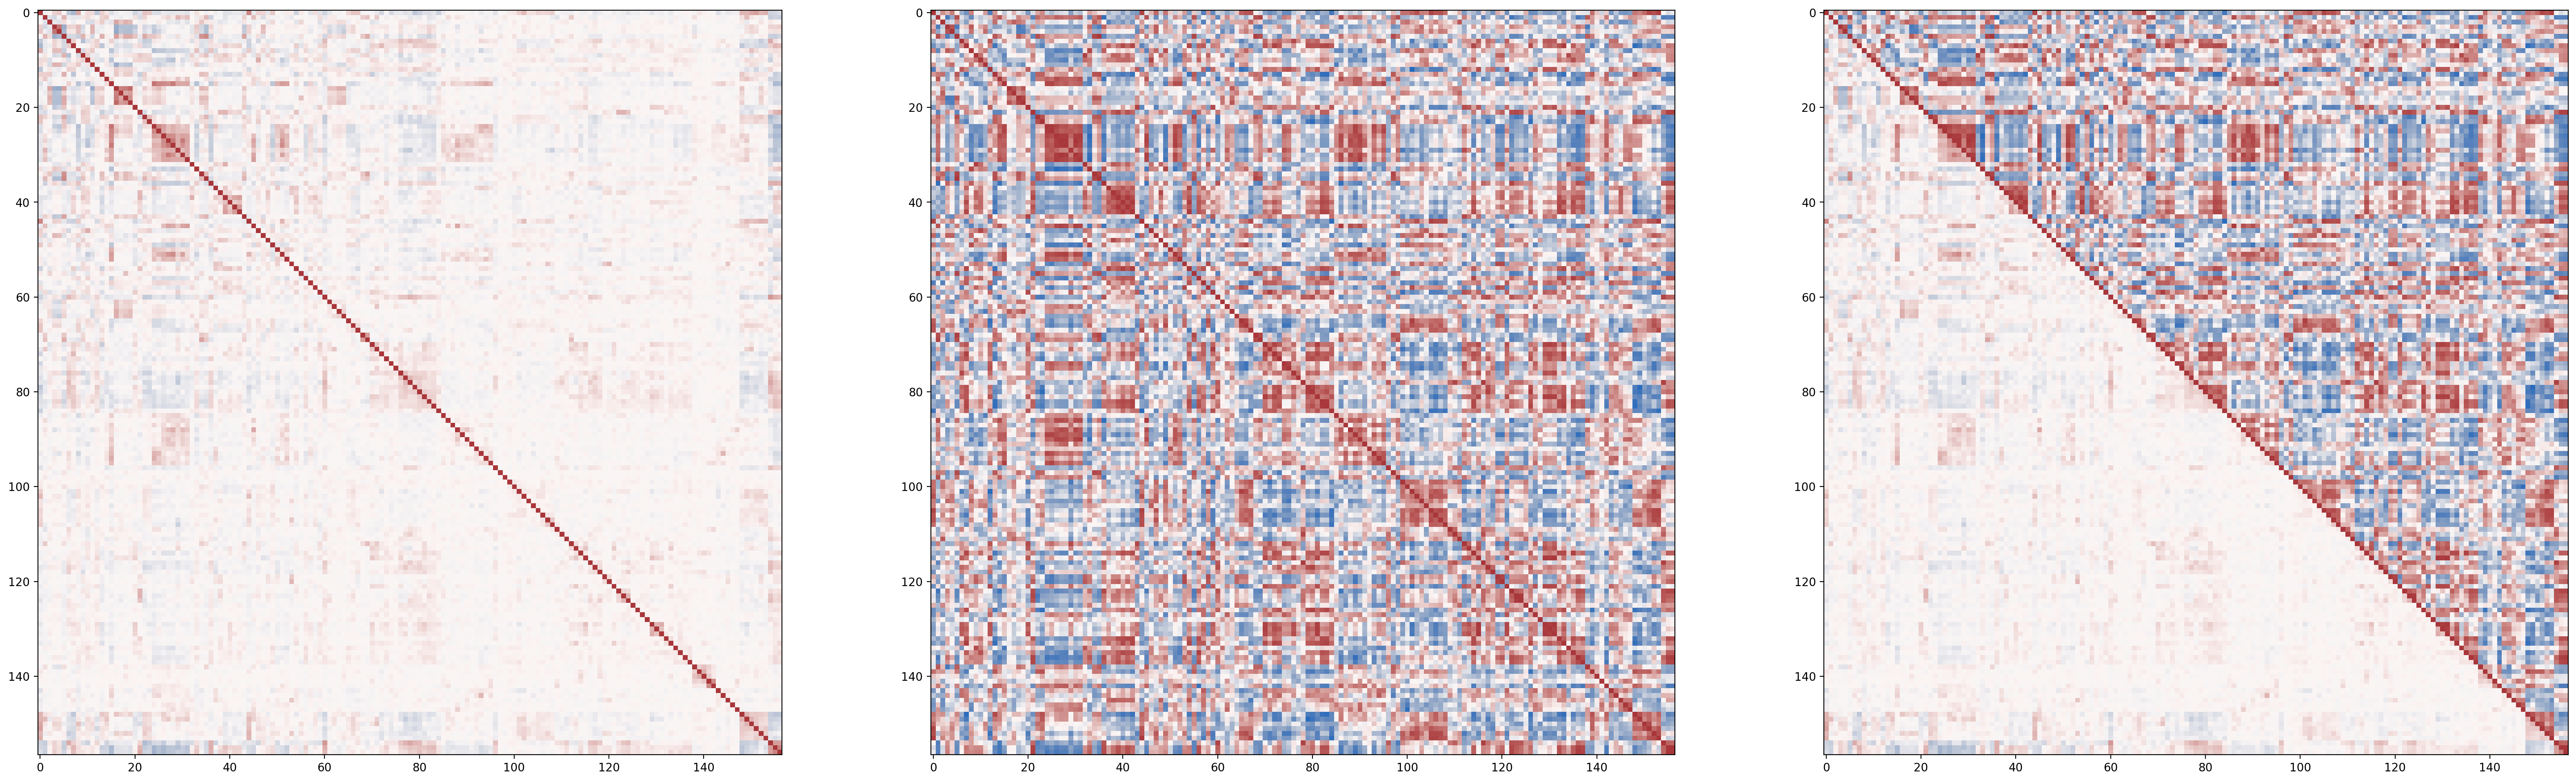

In [62]:
plt.figure(figsize=(40, 20), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(x_cor,cmap="vlag",vmin=-1,vmax=1)
plt.subplot(1, 3, 2)
plt.imshow(xhat_cor,cmap="vlag",vmin=-1,vmax=1)
plt.subplot(1, 3, 3)
plt.imshow(xfus,cmap="vlag",vmin=-1,vmax=1)

### Correlations in samples from posterior

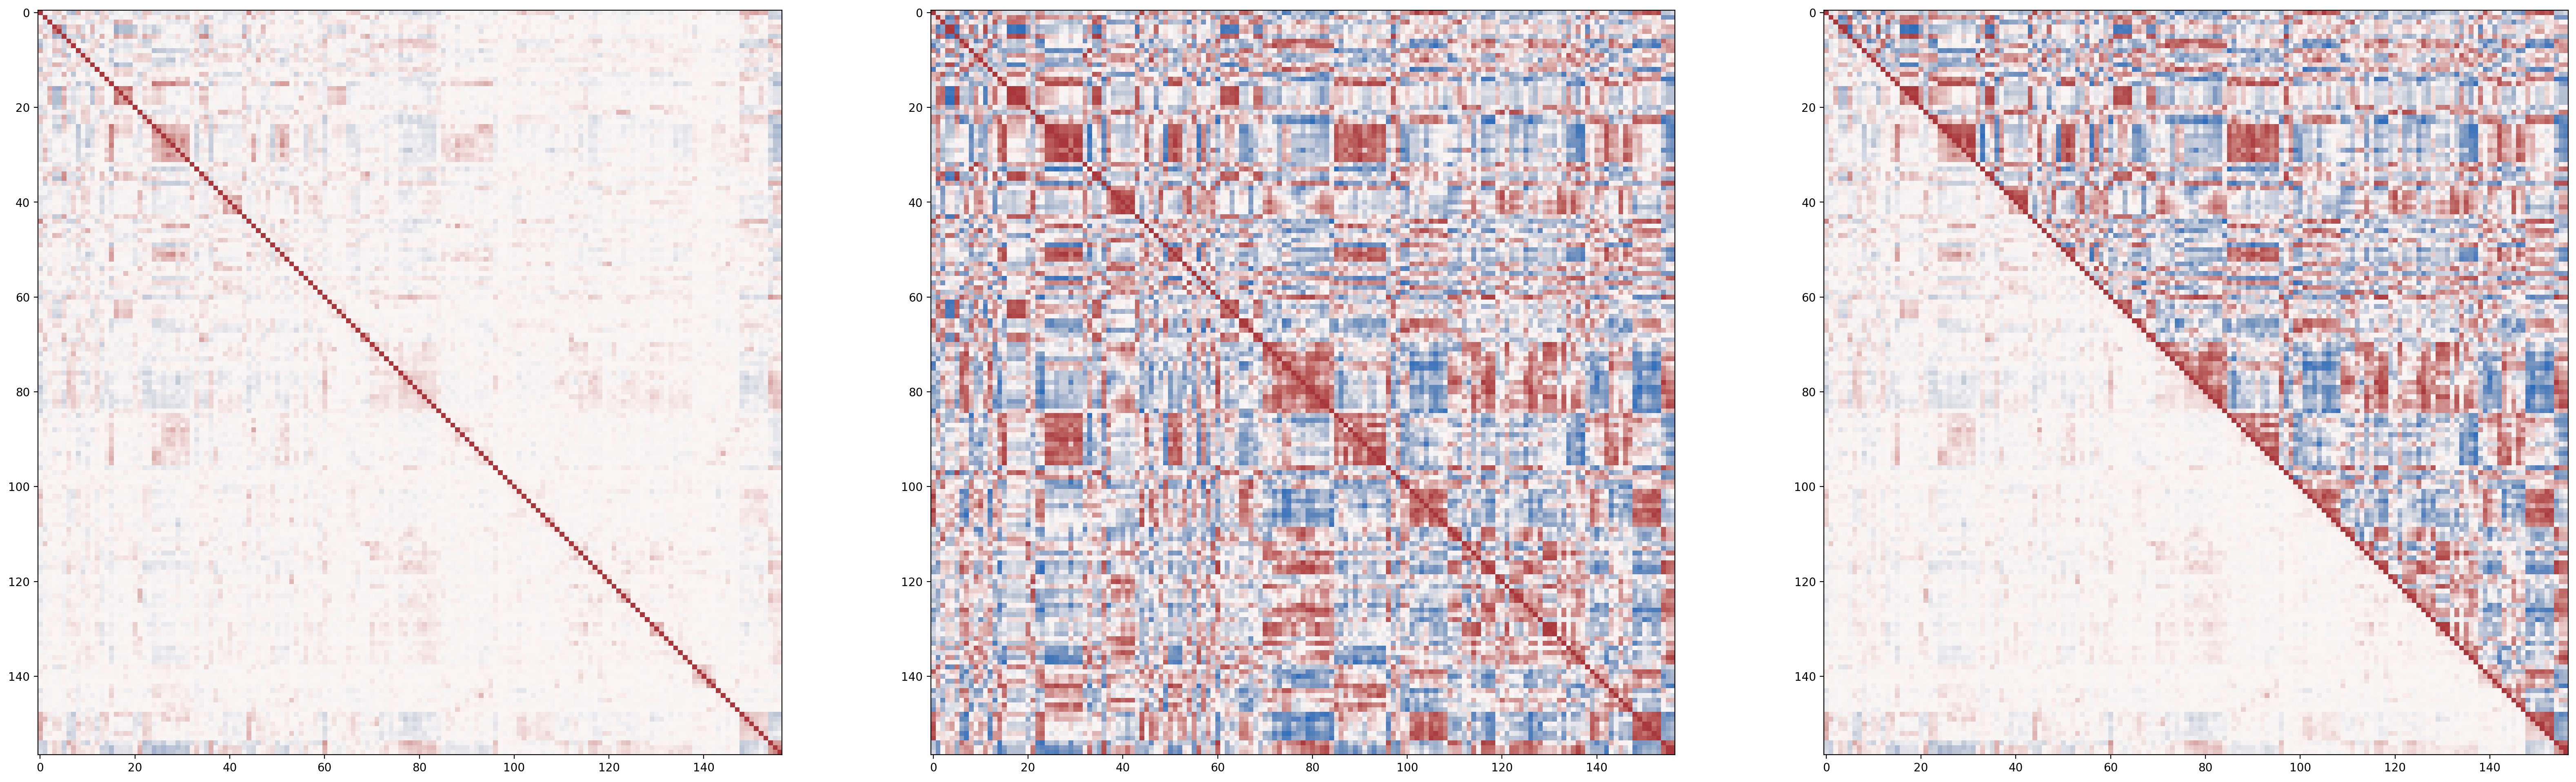

In [63]:
plt.figure(figsize=(40, 20), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(x_cor,cmap="vlag",vmin=-1,vmax=1)
plt.subplot(1, 3, 2)
plt.imshow(xhat_post_cor,cmap="vlag",vmin=-1,vmax=1)
plt.subplot(1, 3, 3)
plt.imshow(x_postfus,cmap="vlag",vmin=-1,vmax=1)

# Interpreting Deep Architectures

In [64]:
class LDVAE(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=20, latent_dim=2):
        super(LDVAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.tanh(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, log_var = self.encode(x)
        #print(mu)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [65]:
dstrain, dstest, traincols, testcols, genes = prepare_pytorch(df,gabagluta01,cols,genenames,cutoff=10,min_cells=20,split=0.9, quant=.9)

In [66]:
ldvae = LDVAE(input_dim=dstrain.x.shape[1], hidden_dim=100, latent_dim=2)
trainloss, testloss = train_model(ldvae, dstrain, dstest, epochs=10, is_vae=True,klfactor=1)

Epoch [1/10] - Train Loss: 675.138667, Test Loss: 620.445703
Epoch [2/10] - Train Loss: 599.157813, Test Loss: 592.205241
Epoch [3/10] - Train Loss: 578.932373, Test Loss: 576.414456
Epoch [4/10] - Train Loss: 566.535069, Test Loss: 565.466545
Epoch [5/10] - Train Loss: 558.147784, Test Loss: 561.491428
Epoch [6/10] - Train Loss: 552.479137, Test Loss: 555.118396
Epoch [7/10] - Train Loss: 547.493533, Test Loss: 549.939600
Epoch [8/10] - Train Loss: 543.050419, Test Loss: 547.131161
Epoch [9/10] - Train Loss: 539.002668, Test Loss: 542.850872
Epoch [10/10] - Train Loss: 535.491526, Test Loss: 539.042338
Training complete.


In [67]:
vae = VAE(input_dim=dstrain.x.shape[1], hidden_dim=100, latent_dim=2)
trainloss, testloss = train_model(vae, dstrain, dstest, epochs=10, is_vae=True,klfactor=1)

Epoch [1/10] - Train Loss: 672.037048, Test Loss: 619.797070
Epoch [2/10] - Train Loss: 606.204727, Test Loss: 596.851210
Epoch [3/10] - Train Loss: 587.758353, Test Loss: 579.917663
Epoch [4/10] - Train Loss: 573.924121, Test Loss: 568.463536
Epoch [5/10] - Train Loss: 562.500808, Test Loss: 559.598699
Epoch [6/10] - Train Loss: 553.584604, Test Loss: 550.096344
Epoch [7/10] - Train Loss: 546.819190, Test Loss: 543.998489
Epoch [8/10] - Train Loss: 540.590792, Test Loss: 538.642519
Epoch [9/10] - Train Loss: 535.322494, Test Loss: 532.300876
Epoch [10/10] - Train Loss: 530.738846, Test Loss: 529.119946
Training complete.


In [68]:
zs_ldvae = sample_posterior(ldvae,dstest.x)[1].detach().numpy()
zs_vae = sample_posterior(vae,dstest.x)[1].detach().numpy()

Text(0, 0.5, 'Z 2')

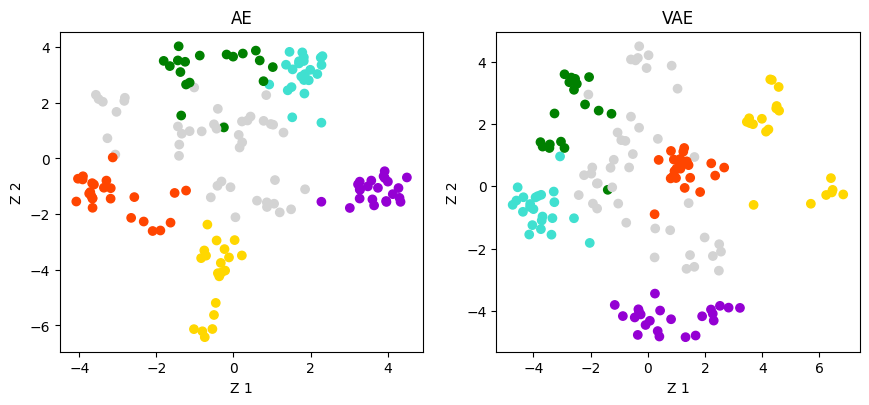

In [69]:
# Plot SVD projections
plt.figure(figsize=(10, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.subplot(1, 2, 1)
plt.scatter(zs_ldvae[:, 0],  zs_ldvae[:, 1],color=testcols)
plt.title('AE')
plt.xlabel('Z 1')
plt.ylabel('Z 2')

plt.subplot(1, 2, 2)
plt.scatter(zs_vae[:, 0],  zs_vae[:, 1],color=testcols)
plt.title('VAE')
plt.xlabel('Z 1')
plt.ylabel('Z 2')

## Implement a Linear decoded VAE (LDVAE)
In the above code cells you see the definition of an LDVAE and code to create a training and test set and tro train the approach and then plotting samples from the posterior distribution.

However it is infact a plain VAE. Your task is now to alter the code of the VAE to turn it into a LDVAE.

 **Hint:** you only have to comment out code and change something in the definition of ``fc4``



### After training we can inspect the loadings of the genes on the latent representations as known from PCA

In [70]:
loadings = ldvae.fc4.weight.detach().numpy()

In [71]:
loadings.shape

(157, 100)

In [72]:
genes

array(['Adora1', 'Adra1a', 'Adra1b', 'Adra1d', 'Adra2a', 'Adrb1', 'Aqp4',
       'Arf5', 'Batf3', 'Bcl6', 'Calb2', 'Car12', 'Car4', 'Cbln4', 'Cd9',
       'Cdh13', 'Chat', 'Chodl', 'Chrm1', 'Chrm2', 'Chrm3', 'Chrm4',
       'Chrna1', 'Chrna2', 'Chrna3', 'Chrna4', 'Chrna5', 'Chrna7',
       'Chrnb1', 'Chrnb2', 'Cnr1', 'Cnr2', 'Col6a1', 'Cpne5', 'Crispld2',
       'Ctgf', 'Ctxn3', 'Cx3cr1', 'Cxcl14', 'Ddit4l', 'Deptor', 'Drd1a',
       'Drd5', 'Enpp2', 'Exosc7', 'F3', 'Foxp2', 'Frmd7', 'Fyn', 'Gabbr1',
       'Gabbr2', 'Gabra1', 'Gabra2', 'Gabra3', 'Gabra4', 'Gabra5',
       'Gabrb1', 'Gabrb2', 'Gabrb3', 'Gabrd', 'Gabrg1', 'Gabrg2',
       'Gabrg3', 'Gja1', 'Glra2', 'Glra3', 'Glrb', 'Gpc3', 'Gpx3',
       'Gria1', 'Gria2', 'Gria3', 'Gria4', 'Grid1', 'Grik1', 'Grik2',
       'Grik3', 'Grik4', 'Grik5', 'Grin1', 'Grin2a', 'Grin2b', 'Grin2d',
       'Grin3a', 'Grina', 'Grm1', 'Grm2', 'Grm3', 'Grm4', 'Grm5', 'Grm7',
       'Grm8', 'Hrh1', 'Hrh2', 'Hrh3', 'Hsd11b1', 'Htr1a', 'Htr1b',
       'H

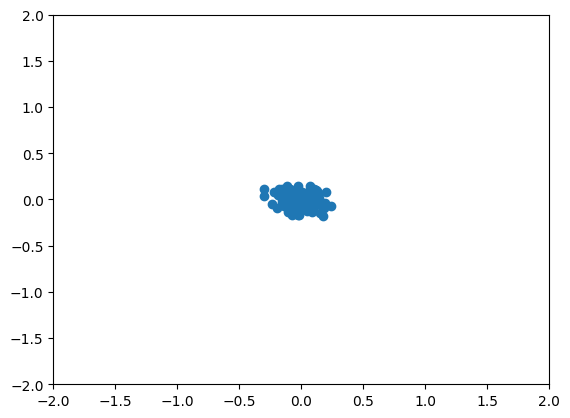

In [73]:
fig, ax = plt.subplots()
ax.scatter(loadings[:, 0], loadings[:, 1])
for i, point in enumerate(loadings):
    if (abs(point[0]) > 1) | (abs(point[1]) > 1):
        ax.annotate(genes[i], (point[0] + 0.1, point[1] + 0.1), fontsize=9)
        ax.arrow(0, 0, point[0], point[1], head_width=0.1, head_length=0.2, fc='gray', ec='gray')
ax.set_xlim([-2, 2]);
ax.set_ylim([-2, 2]);

## Tasks
1. compare the latent representations generated by VAE and LDVAE
  1. do you see any disadvantages in the LDVAE
  2. how is the model architecture related to the latent representations


### Integrated Gradients

### Tasks
1. what is function ``get_scaled_inputs`` doing ?
  1. evaluate code below

In [74]:
def get_scaled_inputs(input,baseline=None,steps=200):
    if baseline is None:
        baseline = torch.zeros_like(input)
    # Scale input and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (input - baseline) for i in range(steps + 1)]
    return baseline, scaled_inputs

In [75]:
scaled_inputs = get_scaled_inputs(dstrain.x)[1]

In [76]:
abs_scores_scaled = [scaled_inputs[i].abs().sum().detach().numpy() for i in range(len(scaled_inputs)) ]

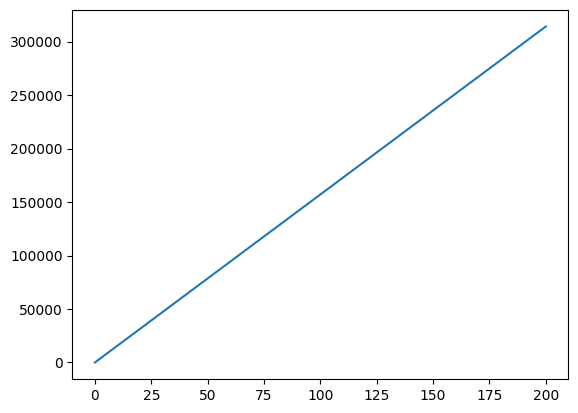

In [77]:
plt.plot(abs_scores_scaled)

In [78]:
scaled_inputs[200].max()

tensor(11.4809)

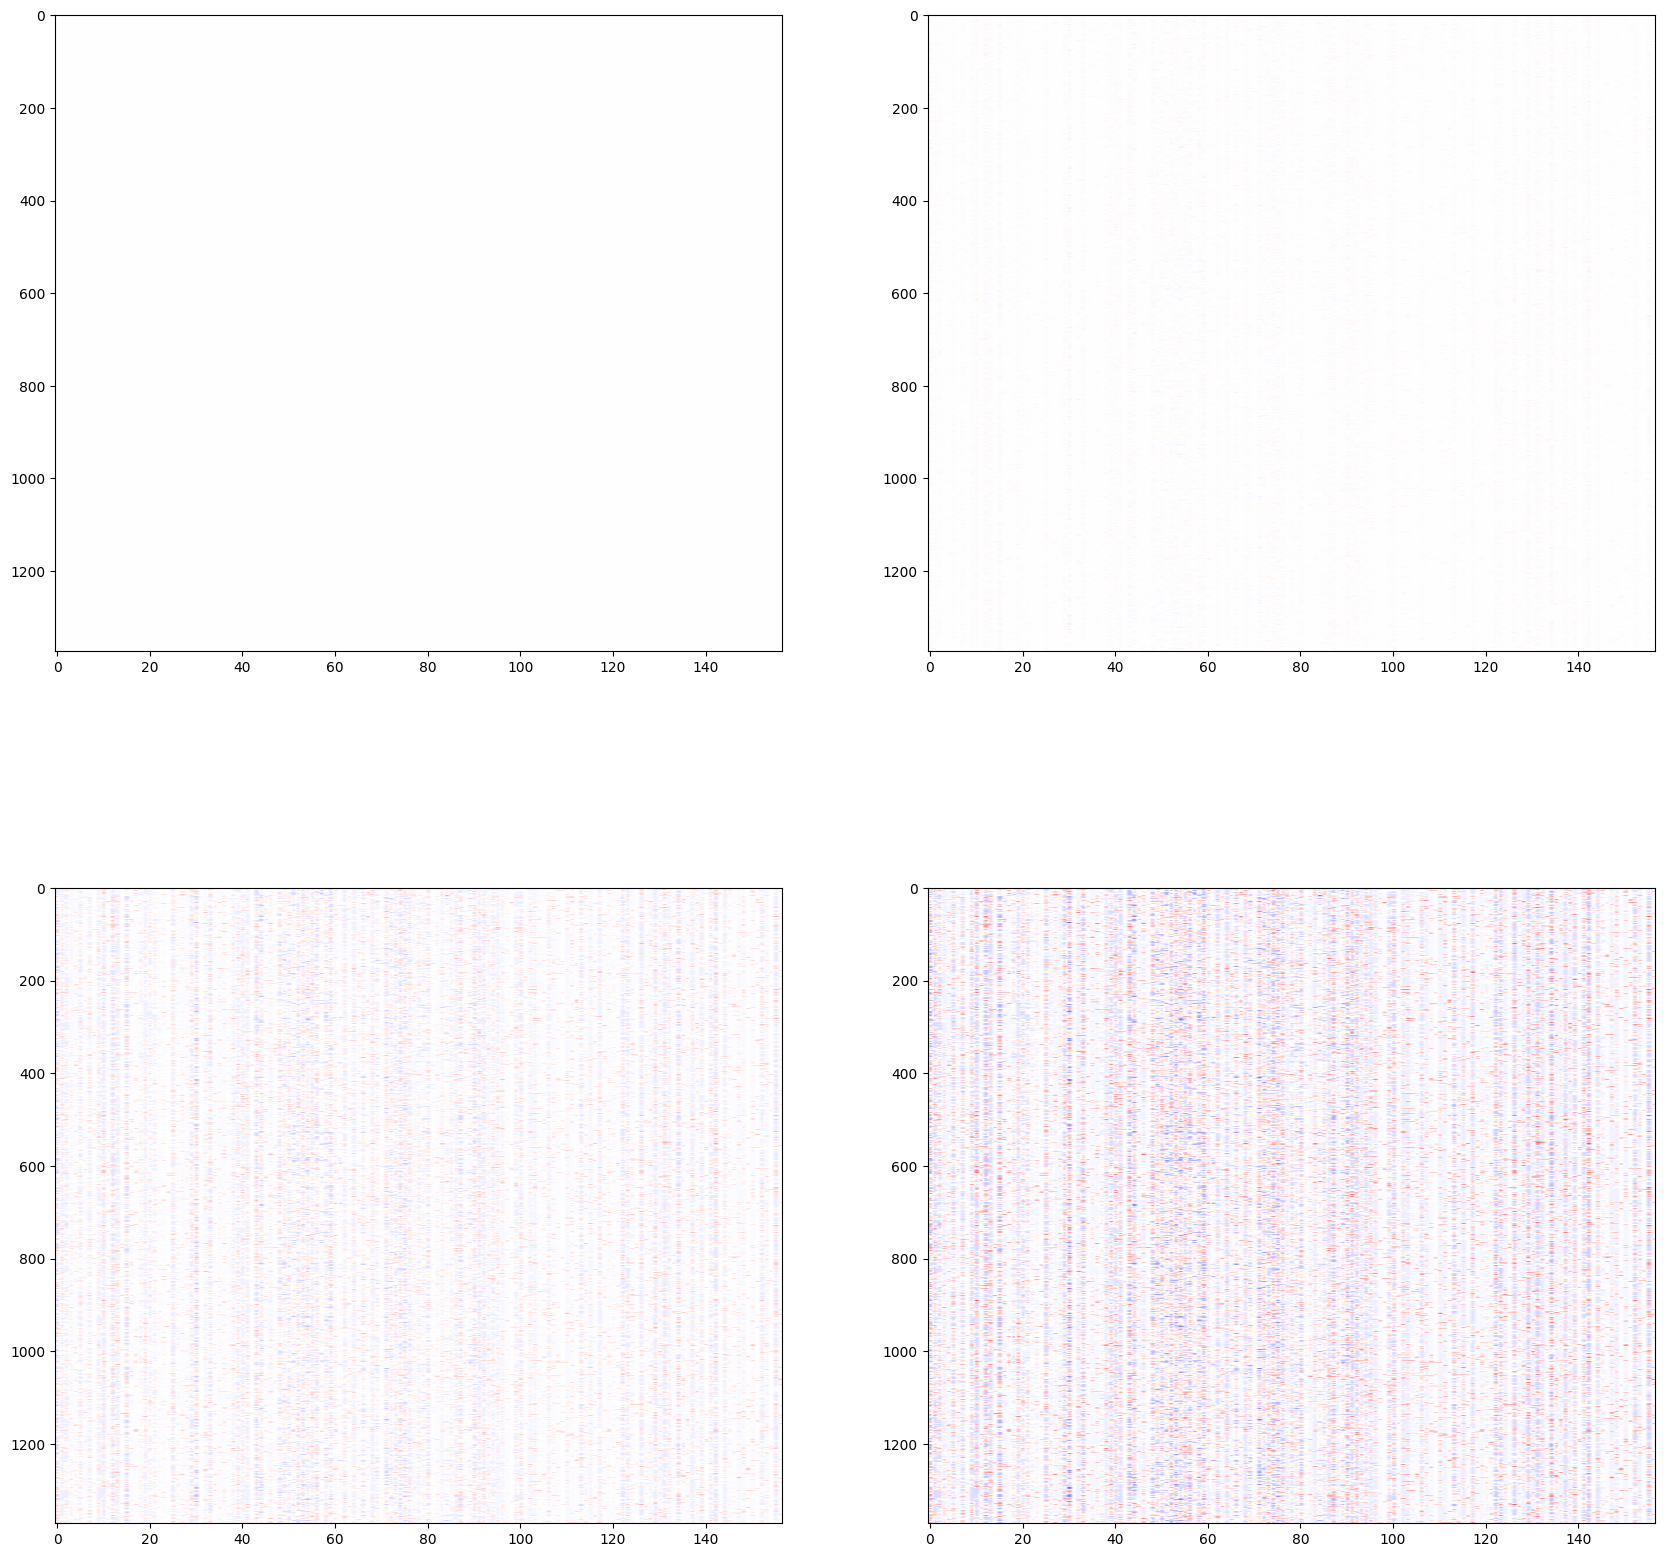

In [79]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.subplot(2, 2, 1)
plt.imshow(scaled_inputs[0],aspect=0.1,cmap='bwr',vmin=-scaled_inputs[200].max(), vmax=scaled_inputs[200].max())
plt.subplot(2, 2, 2)
plt.imshow(scaled_inputs[20],aspect=0.1,cmap='bwr',vmin=-scaled_inputs[200].max(), vmax=scaled_inputs[200].max())
plt.subplot(2, 2, 3)
plt.imshow(scaled_inputs[100],aspect=0.1,cmap='bwr',vmin=-scaled_inputs[200].max(), vmax=scaled_inputs[200].max())
plt.subplot(2, 2, 4)
plt.imshow(scaled_inputs[200],aspect=0.1,cmap='bwr',vmin=-scaled_inputs[200].max(), vmax=scaled_inputs[200].max())

### Tasks
1. How does the Baseline change the results in terms of important genes and integrated gradients per observation
  1. you can play with the parameter ``baseline``

In [80]:
def integrated_gradients(input, model, target_latent_var, baseline=None, steps=200):
    baseline, scaled_inputs = get_scaled_inputs(input,steps=steps,baseline=baseline)
    #print(scaled_inputs)
    grads = []
    for scaled_input in scaled_inputs:
        scaled_input.requires_grad_(True)
        #print(scaled_input)
        mu, _ = model.encode(scaled_input)
        #print(mu)
        output = mu[:, target_latent_var]
        #print(output)
        #print(torch.ones_like(output))
        #output.backward(output)
        output.backward(torch.ones_like(output))
        #print(grads)
        grads.append(scaled_input.grad.detach())
    avg_grads = torch.mean(torch.stack(grads), dim=0)
    integrated_grads = (input - baseline) * avg_grads

    return integrated_grads

In [81]:
igresmat0 = integrated_gradients(dstrain.x,vae,0,steps=200,baseline=None)#torch.full(dstrain.x.shape,-3))

In [82]:
igresmat1 = integrated_gradients(dstrain.x,vae,1,steps=200)

In [83]:
avg_imp0 = abs(igresmat0).mean(axis=0)
avg_imp1 = abs(igresmat1).mean(axis=0)
sel0 = avg_imp0>.15
sel1 = avg_imp1>.15
sel = (sel0) | (sel1)

In [84]:
genes[sel0]

array(['Adora1', 'Car4', 'Cdh13', 'Cnr1', 'Gabra1', 'Grik1', 'Grin3a',
       'Parm1', 'Reln', 'Rorb', 'Sst'], dtype=object)

In [85]:
genes[sel1]

array(['Adora1', 'Calb2', 'Car4', 'Gabra3', 'Gabra5', 'Gria3', 'Grik3',
       'Grm3', 'Myl4', 'Penk', 'Sst', 'Vip'], dtype=object)

In [86]:
igresmat0 = igresmat0[:,sel0]
igresmat1 = igresmat1[:,sel1]
genes0 = genes[sel0]
genes1 = genes[sel1]


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 80x80 with 0 Axes>

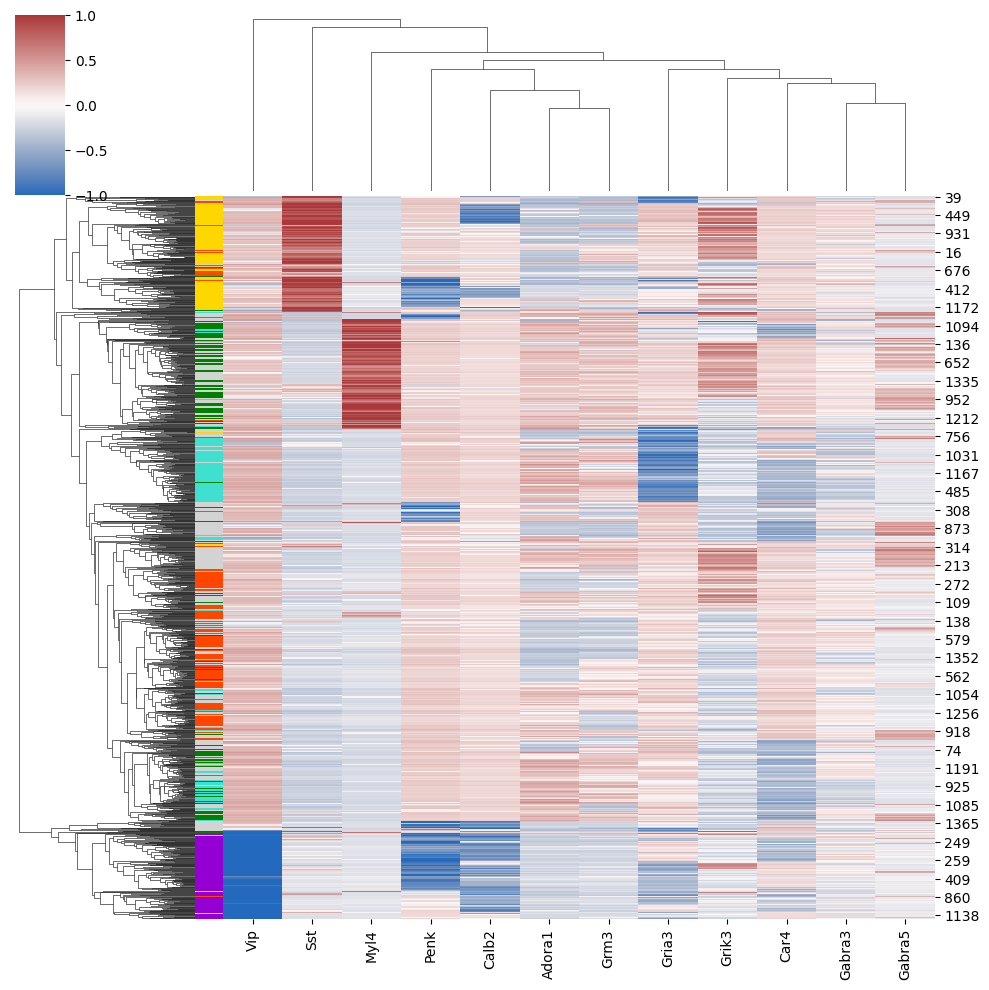

In [87]:
plt.figure(figsize=(4, 4), dpi=20)
seaborn.clustermap(igresmat1,row_colors=traincols,cmap="vlag",xticklabels=genes1,vmin=-1,vmax=1,center=0)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


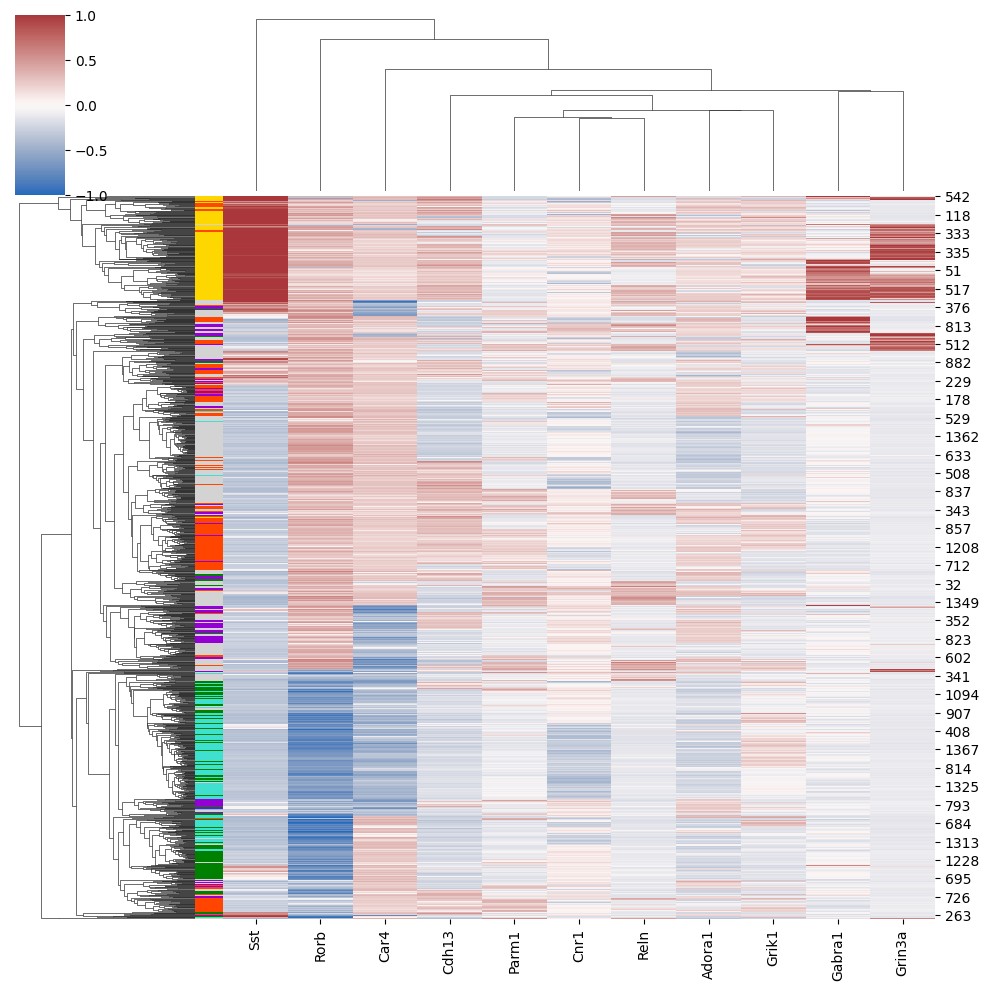

In [88]:
seaborn.clustermap(igresmat0,row_colors=traincols,cmap="vlag",xticklabels=genes0,vmin=-1,vmax=1,center=0)

In [89]:
igresmat0 = integrated_gradients(dstrain.x,vae,0,steps=10,baseline=None).detach().numpy()
igresmat1 = integrated_gradients(dstrain.x,vae,1,steps=10,baseline=None).detach().numpy()

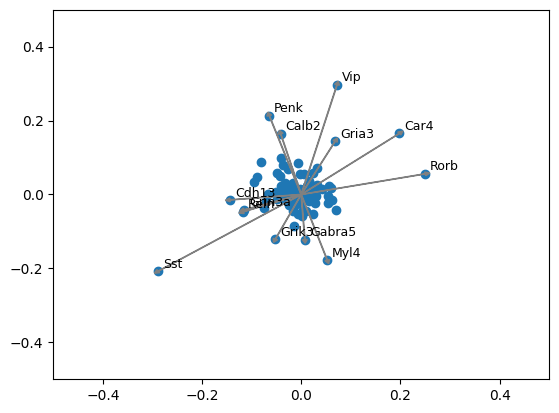

In [90]:
### Plotting median of gradients computed over trainingsamples / simlar to plot in LDVAE
igloadings =  np.column_stack((np.quantile(igresmat0,0.5,axis=0),
                              np.quantile(igresmat1,0.5,axis=0)))

fig, ax = plt.subplots()
ax.scatter(igloadings[:,0],igloadings[:,1])
for i, point in enumerate(igloadings):
    if (abs(point[0]) > 0.1) | (abs(point[1]) > 0.1):
        ax.annotate(genes[i], (point[0] + 0.01, point[1] + 0.01), fontsize=9)
        ax.arrow(0, 0, point[0], point[1], head_width=0.01, head_length=0.01, fc='gray', ec='gray')
ax.set_xlim([-0.5, 0.5]);
ax.set_ylim([-0.5, 0.5]);

## END
